In [1]:
data = '/home/boris/projects/VoiceSpeaker/Multi-lingual Phoneme Recognition/data/raw_kaggle/Speeches.xlsx'

In [2]:
import math
import os

import jiwer
from matplotlib import pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
import librosa

import torchaudio

# Data loading

In [3]:
BATCH_SIZE = 1

In [4]:
df = pd.read_excel(data)
df.head()

,Число,Русская речь
0,1,Как пройти до корпуса?
1,2,Где взять направление?
2,3,Бумага есть
3,4,анальгин
4,5,вата


In [5]:
import subprocess
def get_audio_path(i: int) -> str | bool:
    candidates = [
        '/home/boris/projects/VoiceSpeaker/Multi-lingual Phoneme Recognition/data/Борис. Фразы(0-100)/{}.m4a'.format(i),
        '/home/boris/projects/VoiceSpeaker/Multi-lingual Phoneme Recognition/data/Борис. Фразы(101-238/{}.m4a'.format(i),
        '/home/boris/projects/VoiceSpeaker/Multi-lingual Phoneme Recognition/data/Борис. Фразы(239-399)/{}.m4a'.format(i),
    ]
    for path in candidates:
        if os.path.exists(path):
            if not os.path.exists(path+'.wav'):
                subprocess.run(['ffmpeg', '-i', path, path+'.wav'])
            return path+'.wav'
    return False
def get_audio(path: str):
    return torch.Tensor(librosa.load(path, sr=16000)[0]).view(1,-1)

In [6]:
get_audio_path(4)

False

In [7]:
missed_files = []
for i in df.iterrows():
    num = i[0]
    if not get_audio_path(num):
        missed_files.append(num)
missed_files

[0,
 1,
 2,
 3,
 4,
 6,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 20,
 21,
 22,
 24,
 25,
 26,
 27,
 28,
 30,
 32,
 33,
 34,
 35,
 36,
 37,
 40,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 60,
 61,
 62,
 65,
 66,
 67,
 68,
 69,
 70,
 73,
 75,
 76,
 79,
 80,
 81,
 82,
 83,
 84,
 87,
 89,
 90,
 91,
 93,
 94,
 96,
 99,
 100,
 101,
 102,
 103,
 104,
 106,
 108,
 109,
 110,
 111,
 113,
 114,
 115,
 116,
 117,
 119,
 120,
 122,
 123,
 125,
 126,
 127,
 128,
 129,
 130,
 132,
 133,
 134,
 135,
 136,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 160,
 161,
 162,
 163,
 165,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 178,
 179,
 180,
 181,
 182,
 184,
 185,
 186,
 187,
 189,
 190,
 191,
 192,
 193,
 194,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221

In [8]:
len(missed_files)/len(df)

0.8025

In [9]:
missed_files[0]

0

In [10]:

for i in missed_files:
    df = df[df['Число']!=i]


In [11]:
df.reset_index(inplace=True, drop=True)

In [12]:
df.head()

,Число,Русская речь
0,5,вата
1,7,Где преподаватель?
2,19,Столовая прямо по коридору
3,23,Лабиринт
4,29,Ограничения


In [13]:
librosa.load(get_audio_path(23))

(array([-8.8853506e-07,  1.1100863e-06, -1.5497349e-06, ...,
         6.3932021e-05,  6.5215681e-07, -2.0521853e-05], dtype=float32),
 22050)

In [14]:
class SpeechDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, start=0, end=2000):
        self.df = df
        self.start=start
        self.end=end
    def __len__(self):
        return self.end - self.start
    def __getitem__(self, idx: int):
        new_idx = idx+self.start
        return get_audio(get_audio_path(self.df["Число"][new_idx])), self.df["Русская речь"][new_idx]
abc = '?абвгдеёжзийклмнопрстуфхшщчцьыъэюя'
def collate_spl(batch):
    wfs, lbls = [], []
    for i,j in batch:
        wfs.append(i)
        lbls.append(j)
    
    return  wfs, lbls
def clear_str(s): return ''.join(i for i in s.lower() if i in abc)

In [15]:
def str_to_tensor(strs: list[str])->tuple[torch.Tensor, torch.Tensor]:
    lengths = torch.zeros((len(strs),), dtype=int)
    result = []
    for idx, i in enumerate(strs):
        result.append([abc.index(j) for j in i.lower() if j in abc[1:]])
        lengths[idx] = len(result[-1])
    res_tensor = torch.zeros((len(strs), lengths.max().item()))
    for idx0, i in enumerate(result):
        for idx1, c in enumerate(i):
            res_tensor[idx0, idx1] = c
    return res_tensor, lengths

In [16]:
train_transforms = torchaudio.transforms.MelSpectrogram(
    n_mels=128
    )

/home/boris/projects/VoiceSpeaker/Multi-lingual Phoneme Recognition/venv/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


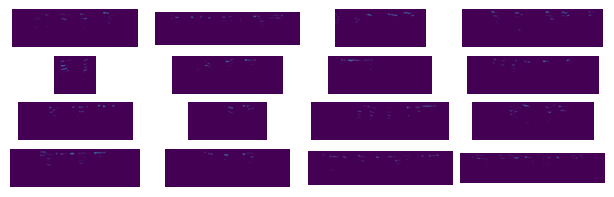

In [17]:
fig, axs = plt.subplots(4,4, layout='compressed')
k = 0
for i in range(4):
    for j in range(4):
        while True:
            p = get_audio_path(k)
            k += 1
            if   p:
                break
        wf = get_audio(p)
        axs[i,j].set_axis_off()
        axs[j,i].imshow(train_transforms(wf)[0])

In [18]:
len(df)

396

In [19]:
device = 'cpu'#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [20]:
train_df = SpeechDataset(df, 0, 300)
val_df = SpeechDataset(df, 300, 395)

In [21]:
def padded_stack(list_of_tensors, maxlen=16):
    maxlen = max(x.shape[1] for x in list_of_tensors)
    output = torch.zeros((len(list_of_tensors), maxlen, list_of_tensors[0].shape[-1]))
    for i, t in enumerate(list_of_tensors):
        output[i, :min(maxlen, t.shape[1]), :] = t[0,:maxlen, :]
    return output

In [22]:
train_dataloader = DataLoader(train_df, batch_size=BATCH_SIZE, collate_fn=collate_spl, shuffle=True)
val_dataloader = DataLoader(val_df, batch_size=BATCH_SIZE, collate_fn=collate_spl, shuffle=True)

In [60]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),
        )
        self.rnn = nn.GRU(input_size=64, 
                    hidden_size=256, 
                    num_layers=1, 
                    batch_first=True, 
                    bidirectional=True)
        
        self.fc = nn.Linear(512, 34)
        self.act = nn.LogSoftmax(-1)
    
    def forward(self, X):
        # X: batch x 128 x len
        # X = X[:,:,::4] 
        X = self.cnn(X)
        X = X.permute(0,2,1)
        X, _ = self.rnn(X)
        X = self.fc(X)
        X = self.act(X)
        return X

model=Model().to(device)

In [61]:
print('params: ', sum(i.nelement() for i in model.parameters()))

params:  586338


In [62]:
loss = nn.CTCLoss(zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters())

In [63]:
def get_y_lengths(y):
    return torch.ones(y.shape[0], dtype=int)*y.shape[-2]

In [64]:
import tqdm

In [65]:
def train_step():
    history = [0]
    model.train()
    i=0
    r=[]
    target = []
    optimizer.zero_grad()
    for batch in tqdm.tqdm(train_dataloader):
        i+=1
        spectrograms = [train_transforms(i).permute(0,2,1) for i in batch[0]]
        spectrograms = padded_stack(spectrograms).permute(0,2,1) # baatch x features x len
        target_t, target_len = str_to_tensor(batch[1])
        target += [clear_str(i) for i in batch[1]]
        output = model(spectrograms.to(device))
        lv = loss(output.permute(1,0,2), target_t.to(device), get_y_lengths(output), target_len)
        lve= torch.exp(lv).item()
        history.append(lve)
        r.append(output.argmax(-1))
        
        lv.backward()
        if i%1==0:
            optimizer.step()
            optimizer.zero_grad()
    return history, r, target
# hist, r, target = train_step()

In [66]:
def val_step():
    history = [0]
    model.eval()
    i=0
    r=[]
    target = []
    for batch in tqdm.tqdm(val_dataloader):
        i+=1
        spectrograms = [train_transforms(i).permute(0,2,1) for i in batch[0]]
        spectrograms = padded_stack(spectrograms).permute(0,2,1) # baatch x features x len
        target += [clear_str(i) for i in batch[1]]
        target_t, target_len = str_to_tensor(batch[1])
        output = model(spectrograms)
        lv = loss(output.permute(1,0,2), target_t, get_y_lengths(output), target_len)
        lve= torch.exp(lv).item()
        history.append(lve)
        r.append(output.argmax(-1))
        
    return history, r, target
# hist, r, arget = val_step()

In [67]:
_=val_step()

100%|██████████| 95/95 [00:03<00:00, 28.54it/s]


In [68]:
def show_batch(r, target):
    am = r
    for i in range(am.shape[0]):
        p=0
        s=''
        for j in range(am.shape[1]):
            if (c:=am[i,j]) not in [0, p]:
                s+=abc[c]
                p=c
        print(s, 'cer: ', jiwer.cer(s, target) if len(s)>0 else -1)

In [69]:
show_batch(r[-1], arget[-1])

NameError: name 'arget' is not defined

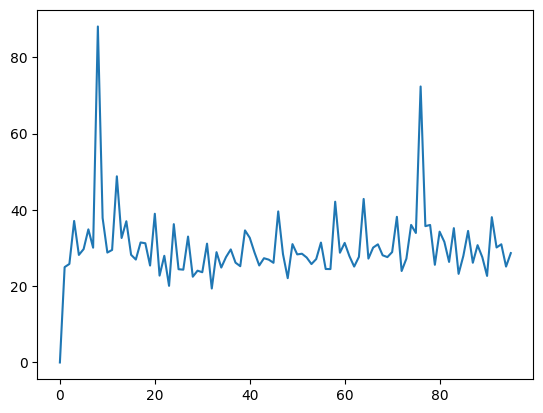

In [70]:
plt.plot(hist)

In [71]:
def to_str(r):
    res=[]
    for i in r:
        res.append([])
        for bn in i:
            res[-1].append(''.join(abc[j] for j in bn))
    return res
def avg_cer(r, target):
    try:
        return sum(jiwer.cer(i, j) for i, j in zip(to_str(r), target))/len(target)
    except:
        return -1
# [clear_str(i) for i in batch[1]]

In [72]:
train_loss=[]
train_cer=[]
val_loss=[]
val_cer=[]

for epoch in range(100):
    print("epoch", epoch)
    hist, r, target = train_step()
    tl = sum(hist)/len(hist)
    train_loss.append(tl)
    print("train loss: ", tl)
    show_batch(r[-1], target[-1])
    show_batch(r[-2], target[-1])
    tc = avg_cer(r, target)
    train_cer.append(tc)
    print("train cer:", tc)
    hist, r, target = val_step()
    vl = sum(hist)/len(hist)
    print("val loss: ", vl)
    val_loss.append(vl)
    show_batch(r[-1], target[-1])
    show_batch(r[-2], target[-1])
    vc = avg_cer(r, target)
    val_cer.append(avg_cer(r, target))
    print("val cer:", vc)

epoch 0


100%|██████████| 300/300 [00:20<00:00, 14.61it/s]


train loss:  4.12237032401825e+19
еа cer:  5.0
аеаеа cer:  2.0
train cer: 0.9794299066873473


100%|██████████| 95/95 [00:03<00:00, 30.61it/s]


val loss:  891.9261620640755
а cer:  10.0
еаеа cer:  2.0
val cer: 0.9811756731284887
epoch 1


100%|██████████| 300/300 [00:21<00:00, 13.90it/s]


train loss:  555.1017085357362
о cer:  15.0
о cer:  15.0
train cer: 0.9829264420727264


100%|██████████| 95/95 [00:03<00:00, 29.94it/s]


val loss:  92.78650943438213
о cer:  9.0
оаоа cer:  2.25
val cer: 0.9873872886164767
epoch 2


100%|██████████| 300/300 [00:18<00:00, 16.16it/s]


train loss:  48.287970710830436
 cer:  -1
 cer:  -1
train cer: 0.9928259896737861


100%|██████████| 95/95 [00:03<00:00, 31.38it/s]


val loss:  33.42478390534719
 cer:  -1
 cer:  -1
val cer: 0.9972622280128765
epoch 3


100%|██████████| 300/300 [00:20<00:00, 14.75it/s]


train loss:  35.43598465269982
 cer:  -1
 cer:  -1
train cer: 0.9984635031602455


100%|██████████| 95/95 [00:02<00:00, 31.71it/s]


val loss:  31.05842888355255
 cer:  -1
 cer:  -1
val cer: 0.9984038223597739
epoch 4


100%|██████████| 300/300 [00:19<00:00, 15.72it/s]


train loss:  41.1679808847928
 cer:  -1
 cer:  -1
train cer: 0.999235070983961


100%|██████████| 95/95 [00:02<00:00, 34.86it/s]


val loss:  30.162191212177277
 cer:  -1
 cer:  -1
val cer: 0.9979128423622301
epoch 5


100%|██████████| 300/300 [00:18<00:00, 16.28it/s]


train loss:  31.97591049726619
 cer:  -1
 cer:  -1
train cer: 0.998298865329967


100%|██████████| 95/95 [00:02<00:00, 32.00it/s]


val loss:  31.703481018543243
ы cer:  28.0
анаы cer:  6.5
val cer: 0.9975616585157091
epoch 6


100%|██████████| 300/300 [00:17<00:00, 16.79it/s]


train loss:  33.52215524210882
 cer:  -1
 cer:  -1
train cer: 0.9991531324251328


100%|██████████| 95/95 [00:02<00:00, 32.82it/s]


val loss:  30.088435570398968
 cer:  -1
 cer:  -1
val cer: 0.997862152993616
epoch 7


100%|██████████| 300/300 [00:19<00:00, 15.25it/s]


train loss:  32.17517241924704
 cer:  -1
 cer:  -1
train cer: 0.9985624058638805


100%|██████████| 95/95 [00:03<00:00, 27.74it/s]


val loss:  34.00495115915934
 cer:  -1
 cer:  -1
val cer: 0.9962747135361343
epoch 8


100%|██████████| 300/300 [00:22<00:00, 13.43it/s]


train loss:  29.90938768988828
ы cer:  29.0
 cer:  -1
train cer: 0.9986980877614365


100%|██████████| 95/95 [00:03<00:00, 29.38it/s]


val loss:  30.15959777434667
 cer:  -1
 cer:  -1
val cer: 0.9964136284556784
epoch 9


100%|██████████| 300/300 [00:21<00:00, 14.08it/s]


train loss:  29.816037174871198
 cer:  -1
ы cer:  17.0
train cer: 0.9982914303413888


100%|██████████| 95/95 [00:03<00:00, 29.81it/s]


val loss:  29.96946366628011
ыны cer:  3.6666666666666665
 cer:  -1
val cer: 0.9970315537915942
epoch 10


100%|██████████| 300/300 [00:18<00:00, 16.62it/s]


train loss:  28.74168356708514
 cer:  -1
 cer:  -1
train cer: 0.9977582513000766


100%|██████████| 95/95 [00:02<00:00, 34.98it/s]


val loss:  30.594810237487156
 cer:  -1
 cer:  -1
val cer: 0.9970063526958469
epoch 11


100%|██████████| 300/300 [00:20<00:00, 14.52it/s]


train loss:  28.39635890187615
й cer:  13.0
 cer:  -1
train cer: 0.997622124942081


100%|██████████| 95/95 [00:02<00:00, 33.68it/s]


val loss:  31.758056084314983
 cer:  -1
нененй cer:  2.8333333333333335
val cer: 0.9964313882226757
epoch 12


100%|██████████| 300/300 [00:16<00:00, 18.40it/s]


train loss:  28.48794442553853
 cer:  -1
 cer:  -1
train cer: 0.9975296188355008


100%|██████████| 95/95 [00:03<00:00, 30.74it/s]


val loss:  31.578257610400517
 cer:  -1
ыйт cer:  8.0
val cer: 0.9965551191509616
epoch 13


100%|██████████| 300/300 [00:15<00:00, 18.84it/s]


train loss:  26.85703045981271
й cer:  15.0
 cer:  -1
train cer: 0.997030124854018


100%|██████████| 95/95 [00:02<00:00, 33.76it/s]


val loss:  30.475503305594128
нй cer:  5.5
й cer:  11.0
val cer: 0.9964019930618805
epoch 14


100%|██████████| 300/300 [00:18<00:00, 16.10it/s]


train loss:  26.874986220831886
 cer:  -1
 cer:  -1
train cer: 0.9957809220584285


100%|██████████| 95/95 [00:02<00:00, 33.55it/s]


val loss:  32.629748483498894
й cer:  16.0
 cer:  -1
val cer: 0.9966879091840282
epoch 15


100%|██████████| 300/300 [00:17<00:00, 17.50it/s]


train loss:  26.36159988732829
 cer:  -1
ый cer:  7.5
train cer: 0.9953856759734331


100%|██████████| 95/95 [00:02<00:00, 33.46it/s]


val loss:  33.936294754346214
 cer:  -1
й cer:  43.0
val cer: 0.9952912147121485
epoch 16


100%|██████████| 300/300 [00:17<00:00, 16.73it/s]


train loss:  25.38743642002245
ний cer:  5.333333333333333
 cer:  -1
train cer: 0.9946348084404372


100%|██████████| 95/95 [00:03<00:00, 30.04it/s]


val loss:  33.10474967956543
 cer:  -1
 cer:  -1
val cer: 0.9954808601821856
epoch 17


100%|██████████| 300/300 [00:19<00:00, 15.77it/s]


train loss:  24.45275806667797
 cer:  -1
ы cer:  21.0
train cer: 0.9936402528167319


100%|██████████| 95/95 [00:03<00:00, 28.98it/s]


val loss:  34.34767694274584
 cer:  -1
 cer:  -1
val cer: 0.9931733018210076
epoch 18


100%|██████████| 300/300 [00:18<00:00, 16.37it/s]


train loss:  24.21434295375482
ный cer:  4.333333333333333
 cer:  -1
train cer: 0.9928319424337898


100%|██████████| 95/95 [00:02<00:00, 33.46it/s]


val loss:  34.603044172128044
 cer:  -1
 cer:  -1
val cer: 0.9947345577823623
epoch 19


100%|██████████| 300/300 [00:20<00:00, 14.96it/s]


train loss:  23.27812838316756
идтн cer:  3.75
ксне cer:  3.75
train cer: 0.9916871114394781


100%|██████████| 95/95 [00:02<00:00, 32.78it/s]


val loss:  39.81798779964447
нисник cer:  6.5
н cer:  43.0
val cer: 0.9910730837730083
epoch 20


100%|██████████| 300/300 [00:18<00:00, 15.80it/s]


train loss:  23.56763848909904
ний cer:  4.0
кйк cer:  4.0
train cer: 0.9909807368834401


100%|██████████| 95/95 [00:03<00:00, 30.94it/s]


val loss:  35.59490322073301
ий cer:  18.0
ыйниыке cer:  4.714285714285714
val cer: 0.9907498580404808
epoch 21


100%|██████████| 300/300 [00:15<00:00, 18.86it/s]


train loss:  22.154406595071684
ы cer:  14.0
 cer:  -1
train cer: 0.9894328162195374


100%|██████████| 95/95 [00:02<00:00, 33.65it/s]


val loss:  35.73643586039543
но cer:  25.5
ый cer:  26.0
val cer: 0.991531858466793
epoch 22


100%|██████████| 300/300 [00:17<00:00, 16.82it/s]


train loss:  21.014831232470137
ный cer:  2.6666666666666665
ной cer:  3.0
train cer: 0.987422086318784


100%|██████████| 95/95 [00:02<00:00, 34.93it/s]


val loss:  36.18725942571958
 cer:  -1
но cer:  7.0
val cer: 0.9916628539894179
epoch 23


100%|██████████| 300/300 [00:19<00:00, 15.43it/s]


train loss:  19.762089513861063
ый cer:  7.0
 cer:  -1
train cer: 0.9864351886927673


100%|██████████| 95/95 [00:02<00:00, 34.64it/s]


val loss:  41.33279465635618
 cer:  -1
ой cer:  5.5
val cer: 0.993195361263457
epoch 24


100%|██████████| 300/300 [00:17<00:00, 17.39it/s]


train loss:  19.239734855601164
ни cer:  8.5
 cer:  -1
train cer: 0.9857024644003836


100%|██████████| 95/95 [00:02<00:00, 36.55it/s]


val loss:  36.8529066046079
и cer:  19.0
 cer:  -1
val cer: 0.9938463129213898
epoch 25


100%|██████████| 300/300 [00:15<00:00, 19.12it/s]


train loss:  19.034382582502904
ут cer:  6.5
ной cer:  4.666666666666667
train cer: 0.9841746559908013


100%|██████████| 95/95 [00:02<00:00, 35.47it/s]


val loss:  40.51250931620598
 cer:  -1
ний cer:  7.333333333333333
val cer: 0.9916862487579823
epoch 26


100%|██████████| 300/300 [00:16<00:00, 18.51it/s]


train loss:  17.430103726561285
на cer:  6.0
с cer:  13.0
train cer: 0.9822322993591027


100%|██████████| 95/95 [00:02<00:00, 33.40it/s]


val loss:  40.603281170129776
оио cer:  8.333333333333334
еткйрьрь cer:  2.75
val cer: 0.9904440319235271
epoch 27


100%|██████████| 300/300 [00:19<00:00, 15.53it/s]


train loss:  15.877295776063026
ой cer:  7.5
нкй cer:  5.0
train cer: 0.9792233923143135


100%|██████████| 95/95 [00:02<00:00, 32.76it/s]


val loss:  42.003540913263954
ныдтнйо cer:  1.4285714285714286
нойдеый cer:  1.4285714285714286
val cer: 0.9876017712889913
epoch 28


100%|██████████| 300/300 [00:20<00:00, 14.63it/s]


train loss:  14.738621905000503
й cer:  10.0
ныйоедына cer:  1.1111111111111112
train cer: 0.9767514400982217


100%|██████████| 95/95 [00:02<00:00, 35.00it/s]


val loss:  44.15079296628634
ий cer:  8.0
ый cer:  7.5
val cer: 0.9887981026237969
epoch 29


100%|██████████| 300/300 [00:17<00:00, 17.21it/s]


train loss:  13.66989833096729
об cer:  2.5
неяв cer:  1.75
train cer: 0.9723636876436278


100%|██████████| 95/95 [00:02<00:00, 32.88it/s]


val loss:  46.21714230378469
 cer:  -1
ней cer:  15.0
val cer: 0.9852653429638956
epoch 30


100%|██████████| 300/300 [00:17<00:00, 17.38it/s]


train loss:  12.470830845278362
дадене cer:  0.3333333333333333
дыки cer:  1.75
train cer: 0.9697281799369997


100%|██████████| 95/95 [00:02<00:00, 32.21it/s]


val loss:  48.084376871585846
кыйзогановусвекяо cer:  1.5294117647058822
онайойтнонойо cer:  2.1538461538461537
val cer: 0.9819430089518892
epoch 31


100%|██████████| 300/300 [00:18<00:00, 16.31it/s]


train loss:  11.3257595431369
ладе cer:  1.0
сыйеи cer:  1.4
train cer: 0.9652866555763453


100%|██████████| 95/95 [00:03<00:00, 30.83it/s]


val loss:  51.80833645661672
по cer:  4.0
оымл cer:  2.0
val cer: 0.9831496374151046
epoch 32


100%|██████████| 300/300 [00:20<00:00, 14.77it/s]


train loss:  10.466642801943808
киултетс cer:  1.25
оаоао cer:  3.2
train cer: 0.9607404418896556


100%|██████████| 95/95 [00:02<00:00, 37.69it/s]


val loss:  52.89137836297353
омвокйно cer:  6.125
оийп cer:  12.5
val cer: 0.981432221876057
epoch 33


100%|██████████| 300/300 [00:20<00:00, 14.43it/s]


train loss:  9.535773667782248
вийп cer:  2.5
свыяи cer:  2.2
train cer: 0.9571380405736407


100%|██████████| 95/95 [00:02<00:00, 33.67it/s]


val loss:  63.96228208144506
аснавонони cer:  3.2
еоыйнойво cer:  3.5555555555555554
val cer: 0.9840751369804107
epoch 34


100%|██████████| 300/300 [00:17<00:00, 16.97it/s]


train loss:  8.5701658084147
выйсогоый cer:  2.111111111111111
морано cer:  3.5
train cer: 0.9514606058847619


100%|██████████| 95/95 [00:02<00:00, 34.47it/s]


val loss:  61.33058828115463
ныйоыосо cer:  4.125
нийаг cer:  7.0
val cer: 0.9803285658002319
epoch 35


100%|██████████| 300/300 [00:17<00:00, 16.84it/s]


train loss:  7.610910165745555
темболо cer:  1.7142857142857142
оли cer:  5.333333333333333
train cer: 0.9470150243463752


100%|██████████| 95/95 [00:03<00:00, 31.51it/s]


val loss:  62.61534023284912
срапнастойомозани cer:  1.3529411764705883
ланайго cer:  4.0
val cer: 0.9786209892636009
epoch 36


100%|██████████| 300/300 [00:19<00:00, 15.74it/s]


train loss:  6.920251512844301
оьдоа cer:  1.2
ьныйша cer:  1.5
train cer: 0.9413595382691143


100%|██████████| 95/95 [00:03<00:00, 31.51it/s]


val loss:  74.18512366215388
ийоб cer:  2.0
оаваяпевекисрзкаь cer:  0.8823529411764706
val cer: 0.980644264083864
epoch 37


100%|██████████| 300/300 [00:19<00:00, 15.30it/s]


train loss:  6.09135665331172
ючодоа cer:  1.3333333333333333
аеаолнуйа cer:  1.2222222222222223
train cer: 0.9352101652359083


100%|██████████| 95/95 [00:03<00:00, 31.62it/s]


val loss:  79.39844920237859
нйяо cer:  5.5
аяоинку cer:  3.2857142857142856
val cer: 0.9792097047838719
epoch 38


100%|██████████| 300/300 [00:20<00:00, 14.95it/s]


train loss:  5.399423858256039
отчный cer:  0.5
уроео cer:  1.8
train cer: 0.9294429445008895


100%|██████████| 95/95 [00:02<00:00, 34.62it/s]


val loss:  86.83522190650304
ской cer:  7.25
есноанойовеьий cer:  1.8571428571428572
val cer: 0.9768512508167994
epoch 39


100%|██████████| 300/300 [00:18<00:00, 16.14it/s]


train loss:  4.9466025979811965
емгивузд cer:  0.875
еасус cer:  2.0
train cer: 0.9240476796828985


100%|██████████| 95/95 [00:02<00:00, 32.14it/s]


val loss:  102.65949726104736
вейдвененася cer:  1.6666666666666667
пвеое cer:  4.0
val cer: 0.9786684246252261
epoch 40


100%|██████████| 300/300 [00:17<00:00, 16.74it/s]


train loss:  4.364001395694441
севопиряпоког cer:  1.1538461538461537
поаяаяениоеныйоен cer:  1.0
train cer: 0.9185641052379478


100%|██████████| 95/95 [00:02<00:00, 33.53it/s]


val loss:  114.14967852830887
ова cer:  5.666666666666667
неореотойоа cer:  1.3636363636363635
val cer: 0.9763663326346221
epoch 41


100%|██████████| 300/300 [00:18<00:00, 16.66it/s]


train loss:  3.885341897359322
неяжиеспоть cer:  1.2727272727272727
музей cer:  4.4
train cer: 0.9132512202557144


100%|██████████| 95/95 [00:02<00:00, 34.80it/s]


val loss:  119.7450426419576
оеной cer:  4.8
принамойви cer:  2.4
val cer: 0.9716366309751794
epoch 42


100%|██████████| 300/300 [00:15<00:00, 18.92it/s]


train loss:  3.4621682301708234
накавочеиястеа cer:  1.2142857142857142
огаини cer:  4.0
train cer: 0.9070730817170478


100%|██████████| 95/95 [00:02<00:00, 32.90it/s]


val loss:  142.4353078007698
ужниочшио cer:  1.6666666666666667
меонопе cer:  2.0
val cer: 0.9751317292036851
epoch 43


100%|██████████| 300/300 [00:21<00:00, 13.78it/s]


train loss:  3.1193097021888656
прываяеседа cer:  0.5454545454545454
темаик cer:  2.3333333333333335
train cer: 0.9009856649509362


100%|██████████| 95/95 [00:02<00:00, 33.70it/s]


val loss:  142.99337540070215
ово cer:  3.3333333333333335
сеоыценойвор cer:  0.9166666666666666
val cer: 0.9748946065800135
epoch 44


100%|██████████| 300/300 [00:19<00:00, 15.19it/s]


train loss:  2.9030555609452766
прячусзасол cer:  0.36363636363636365
найдёшь cer:  2.0
train cer: 0.8987637532804365


100%|██████████| 95/95 [00:02<00:00, 32.29it/s]


val loss:  155.3920315504074
остийп cer:  4.833333333333333
салсасо cer:  4.428571428571429
val cer: 0.9706275022702703
epoch 45


100%|██████████| 300/300 [00:17<00:00, 16.69it/s]


train loss:  2.6496680178911585
содежаи cer:  0.42857142857142855
жвописныйзак cer:  0.9166666666666666
train cer: 0.8938993115987862


100%|██████████| 95/95 [00:02<00:00, 32.90it/s]


val loss:  208.54002408186594
ныгжитая cer:  2.375
коснопзс cer:  2.25
val cer: 0.9746883471324578
epoch 46


100%|██████████| 300/300 [00:20<00:00, 14.93it/s]


train loss:  2.5251668889657206
громкийсме cer:  0.1
заберешьменясуче cer:  0.8125
train cer: 0.8919365585592232


100%|██████████| 95/95 [00:02<00:00, 36.00it/s]


val loss:  218.3677176038424
реоаыйцено cer:  1.1
уатваут cer:  1.7142857142857142
val cer: 0.9687046280050782
epoch 47


100%|██████████| 300/300 [00:21<00:00, 14.06it/s]


train loss:  2.357273646763393
зикасликоможня cer:  0.42857142857142855
глубокийвдо cer:  1.6363636363636365
train cer: 0.8880402736334613


100%|██████████| 95/95 [00:02<00:00, 35.50it/s]


val loss:  205.13863126436868
вуоигтоенойок cer:  0.8461538461538461
паывет cer:  1.5
val cer: 0.9706425115800313
epoch 48


100%|██████████| 300/300 [00:20<00:00, 14.59it/s]


train loss:  2.103446699060079
этобаза cer:  0.0
перасныйцветок cer:  1.0
train cer: 0.8826138773131516


100%|██████████| 95/95 [00:02<00:00, 35.09it/s]


val loss:  278.15390719970065
гкыйчовтлиайасасюое cer:  1.6842105263157894
аоасакаужо cer:  3.2
val cer: 0.9719280318249782
epoch 49


100%|██████████| 300/300 [00:18<00:00, 16.57it/s]


train loss:  1.9359412355676442
моёплатье cer:  0.0
беныйолень cer:  0.9
train cer: 0.879302328471876


100%|██████████| 95/95 [00:02<00:00, 35.27it/s]


val loss:  312.4434231519699
якти cer:  9.25
вейвоаненео cer:  3.090909090909091
val cer: 0.9738955407990093
epoch 50


100%|██████████| 300/300 [00:19<00:00, 15.40it/s]


train loss:  1.7794957529270767
руяныйотмороза cer:  0.07142857142857142
ебнокигаетмячмапля cer:  0.8888888888888888
train cer: 0.8738507317298913


100%|██████████| 95/95 [00:03<00:00, 28.75it/s]


val loss:  318.8768491744995
тнот cer:  6.0
осюиямийнодвявдвноврпсгныт cer:  0.8846153846153846
val cer: 0.9719282081448192
epoch 51


100%|██████████| 300/300 [00:17<00:00, 17.36it/s]


train loss:  1.6523339114711926
сосновыйбор cer:  0.0
семительныйпок cer:  0.7142857142857143
train cer: 0.8704027516076862


100%|██████████| 95/95 [00:02<00:00, 32.33it/s]


val loss:  383.32927042245865
обретыйом cer:  0.8888888888888888
тып cer:  3.0
val cer: 0.9706063382027377
epoch 52


100%|██████████| 300/300 [00:18<00:00, 16.13it/s]


train loss:  1.5707570619361346
солонцеодилсьагорон cer:  0.42105263157894735
густойпар cer:  2.2222222222222223
train cer: 0.8689691585027494


100%|██████████| 95/95 [00:02<00:00, 35.16it/s]


val loss:  443.27358164389926
пвоби cer:  4.0
грогдгдегра cer:  1.4545454545454546
val cer: 0.9700272406659121
epoch 53


100%|██████████| 300/300 [00:18<00:00, 16.27it/s]


train loss:  1.50639618710426
круглаяшлянаголове cer:  0.1111111111111111
громкийсме cer:  1.8
train cer: 0.8656587740432456


100%|██████████| 95/95 [00:02<00:00, 34.69it/s]


val loss:  520.5139126181602
ыйоран cer:  1.5
ненворнойке cer:  0.9090909090909091
val cer: 0.9715816367572939
epoch 54


100%|██████████| 300/300 [00:17<00:00, 17.48it/s]


train loss:  1.4451942130972777
оернутьсяназад cer:  0.07142857142857142
тхийзвукручя cer:  1.25
train cer: 0.8646201062109825


100%|██████████| 95/95 [00:02<00:00, 34.30it/s]


val loss:  578.5735919674238
пар cer:  3.3333333333333335
расивастстксойнамумуоийзацнае cer:  0.9310344827586207
val cer: 0.9703196490718742
epoch 55


100%|██████████| 300/300 [00:17<00:00, 17.59it/s]


train loss:  1.4346037608048448
пособсказать cer:  0.08333333333333333
чениеветанеучениет cer:  0.9444444444444444
train cer: 0.8630928035735186


100%|██████████| 95/95 [00:02<00:00, 34.75it/s]


val loss:  683.5136830409368
кмавистет cer:  1.3333333333333333
квобойи cer:  1.5714285714285714
val cer: 0.9705938632433803
epoch 56


100%|██████████| 300/300 [00:17<00:00, 17.54it/s]


train loss:  1.4037203353108758
облилвдойруско cer:  0.2857142857142857
садкийшоколад cer:  1.2307692307692308
train cer: 0.8624922005648413


100%|██████████| 95/95 [00:02<00:00, 33.98it/s]


val loss:  909.4347035090128
навтрвеотенкереяенореяруо cer:  1.52
стылясток cer:  4.333333333333333
val cer: 0.9724389579295815
epoch 57


100%|██████████| 300/300 [00:19<00:00, 15.11it/s]


train loss:  1.3588634432352262
вызовитемнетаксипожалус cer:  0.13043478260869565
сладкиефрукт cer:  1.8333333333333333
train cer: 0.8610138056740264


100%|██████████| 95/95 [00:02<00:00, 34.69it/s]


val loss:  814.5884650945663
кияуонойкедибгеьокрникренкестин cer:  1.1612903225806452
гуыйорелупоб cer:  3.0833333333333335
val cer: 0.9681964385947849
epoch 58


100%|██████████| 300/300 [00:19<00:00, 15.52it/s]


train loss:  1.31547931737678
хочешьпосмотретьсера cer:  0.15
начальствовызывает cer:  1.0
train cer: 0.8589989373039014


100%|██████████| 95/95 [00:02<00:00, 32.05it/s]


val loss:  991.2477335532507
аикнкалв cer:  1.875
ныийороровюарачкорене cer:  0.8095238095238095
val cer: 0.9680616898852135
epoch 59


100%|██████████| 300/300 [00:18<00:00, 16.41it/s]


train loss:  1.2761238072797705
прячусьзастоло cer:  0.07142857142857142
мыбыхотелипозавтрать cer:  0.85
train cer: 0.8573175558466907


100%|██████████| 95/95 [00:02<00:00, 33.59it/s]


val loss:  1021.8401963909467
ост cer:  3.6666666666666665
аб cer:  6.0
val cer: 0.9717385209927061
epoch 60


100%|██████████| 300/300 [00:19<00:00, 15.02it/s]


train loss:  1.248555295095095
транспорт cer:  0.0
назаднемсидени cer:  0.7857142857142857
train cer: 0.8569596355583067


100%|██████████| 95/95 [00:03<00:00, 31.00it/s]


val loss:  1767.2087238033612
итныйобви cer:  0.7777777777777778
режовсесыйценойвомвомр cer:  0.8181818181818182
val cer: 0.9668151559635241
epoch 61


100%|██████████| 300/300 [00:20<00:00, 14.63it/s]


train loss:  1.2228437230436509
этобаза cer:  0.0
послеполуденоесолнце cer:  0.95
train cer: 0.8551099237498689


100%|██████████| 95/95 [00:02<00:00, 35.57it/s]


val loss:  1366.7602230707805
пвгобйи cer:  2.7142857142857144
буситыйор cer:  2.111111111111111
val cer: 0.97102207632086
epoch 62


100%|██████████| 300/300 [00:18<00:00, 16.02it/s]


train loss:  1.2044627650631623
почемувсетаксложно cer:  0.0
рабтанадошибкамиключкуспеу cer:  0.9230769230769231
train cer: 0.8554981176520958


100%|██████████| 95/95 [00:03<00:00, 29.75it/s]


val loss:  1413.4089060823123
среоврсыйсенойомор cer:  0.7222222222222222
поб cer:  4.0
val cer: 0.9703199261164638
epoch 63


100%|██████████| 300/300 [00:19<00:00, 15.31it/s]


train loss:  1.1911197211655271
яегораскусил cer:  0.0
румяныйотмороза cer:  0.9333333333333333
train cer: 0.8550298987970092


100%|██████████| 95/95 [00:02<00:00, 33.54it/s]


val loss:  1724.0359652837117
итотрийри cer:  1.5555555555555556
ховужрворгроромдугвеноеьнойи cer:  0.7857142857142857
val cer: 0.9693692667443393
epoch 64


100%|██████████| 300/300 [00:17<00:00, 17.25it/s]


train loss:  1.1839155228034999
витаминыдлякожи cer:  0.0
нежныйвкусмалы cer:  1.0714285714285714
train cer: 0.8542480942904748


100%|██████████| 95/95 [00:02<00:00, 33.18it/s]


val loss:  2659.57279864947
ненейжизгонор cer:  1.8461538461538463
хныйзогебилцтоыватавтстнткуснвмемкскевадат cer:  0.8333333333333334
val cer: 0.9669887504051481
epoch 65


100%|██████████| 300/300 [00:15<00:00, 19.86it/s]


train loss:  1.172255923977722
холодныйветердуетсгор cer:  0.0
тальствовсёвремяменяется cer:  0.8333333333333334
train cer: 0.8537873170757987


100%|██████████| 95/95 [00:02<00:00, 35.62it/s]


val loss:  2712.2590338389077
тывраз cer:  4.333333333333333
соечоера cer:  3.125
val cer: 0.9703771043116932
epoch 66


100%|██████████| 300/300 [00:16<00:00, 18.62it/s]


train loss:  1.1624462362935772
яникогданеувижусолнце cer:  0.0
такситакса cer:  1.8
train cer: 0.85391790135626


100%|██████████| 95/95 [00:02<00:00, 34.52it/s]


val loss:  2787.1018367211022
рвенвоатныйвнове cer:  0.875
алсласо cer:  1.8571428571428572
val cer: 0.969457646661786
epoch 67


100%|██████████| 300/300 [00:19<00:00, 15.62it/s]


train loss:  1.148357129572238
морскойзалив cer:  0.0
сладкийзапах cer:  0.6666666666666666
train cer: 0.8530519091064793


100%|██████████| 95/95 [00:02<00:00, 32.47it/s]


val loss:  2677.492285927137
чаонасктвокакяокой cer:  1.6111111111111112
хотоивенолнайтйвромнойоко cer:  1.2
val cer: 0.9672999273074327
epoch 68


100%|██████████| 300/300 [00:20<00:00, 14.72it/s]


train loss:  1.1395439032304326
манеж cer:  0.0
ребенокиграетсмячомнапляже cer:  0.8846153846153846
train cer: 0.8524987861557827


100%|██████████| 95/95 [00:03<00:00, 30.27it/s]


val loss:  2631.917794148127
ипниыйовийеапна cer:  2.066666666666667
чанатоялюкяконй cer:  2.1333333333333333
val cer: 0.9698960365912999
epoch 69


100%|██████████| 300/300 [00:21<00:00, 14.13it/s]


train loss:  1.1271411830008624
сосновыйбор cer:  0.0
разноцветныецветыналугу cer:  0.8260869565217391
train cer: 0.8519942099313361


100%|██████████| 95/95 [00:02<00:00, 32.38it/s]


val loss:  3565.432692925135
аувейнвоанейнме cer:  1.1333333333333333
онмпогогара cer:  1.7272727272727273
val cer: 0.9719655458786193
epoch 70


100%|██████████| 300/300 [00:17<00:00, 17.30it/s]


train loss:  1.1208598962257867
звукморскихволнапобережье cer:  0.04
варитькофесоль cer:  1.4285714285714286
train cer: 0.8517755364533388


100%|██████████| 95/95 [00:02<00:00, 32.28it/s]


val loss:  3139.7661064863205
зеуныситеиосб cer:  1.4615384615384615
отмлспор cer:  2.375
val cer: 0.9667353829946913
epoch 71


100%|██████████| 300/300 [00:18<00:00, 16.46it/s]


train loss:  1.115695224251858
щапогоди cer:  0.0
теплыйветер cer:  0.9090909090909091
train cer: 0.8514481593205587


100%|██████████| 95/95 [00:02<00:00, 36.42it/s]


val loss:  4669.615690251191
йаеусдбе cer:  1.5
хораодокношншапае cer:  0.8235294117647058
val cer: 0.9691027010862726
epoch 72


100%|██████████| 300/300 [00:16<00:00, 18.07it/s]


train loss:  1.101667096052455
владелец cer:  0.0
красивыеромашки cer:  0.8666666666666667
train cer: 0.8514155045976807


100%|██████████| 95/95 [00:02<00:00, 33.74it/s]


val loss:  5063.471997698148
ононсшеьае cer:  3.1
сиотроваучорене cer:  1.9333333333333333
val cer: 0.969200382909896
epoch 73


100%|██████████| 300/300 [00:18<00:00, 16.50it/s]


train loss:  1.1006487132702951
сияющийдрагоценыйкамень cer:  0.043478260869565216
адрес cer:  4.2
train cer: 0.851388633061721


100%|██████████| 95/95 [00:02<00:00, 35.94it/s]


val loss:  5156.163604656856
соыйрелеупобях cer:  1.2857142857142858
хоцононаишьае cer:  1.3076923076923077
val cer: 0.9685394825239263
epoch 74


100%|██████████| 300/300 [00:18<00:00, 16.19it/s]


train loss:  1.1018843472598003
гоненокрасныйзакат cer:  0.16666666666666666
начальствовызывает cer:  0.8888888888888888
train cer: 0.8511137564850231


100%|██████████| 95/95 [00:03<00:00, 31.47it/s]


val loss:  7660.880288441976
яоволвкосоеоеоесевосда cer:  1.3181818181818181
ойуйтйкдла cer:  3.4
val cer: 0.968845285882247
epoch 75


100%|██████████| 300/300 [00:14<00:00, 20.14it/s]


train loss:  1.0928645930020913
круглаяшляанаголове cer:  0.05263157894736842
гласвопиющеговпустыне cer:  0.8571428571428571
train cer: 0.8512540130155414


100%|██████████| 95/95 [00:02<00:00, 34.47it/s]


val loss:  4329.82548101743
чанатолюкякоеь cer:  2.0
мукити cer:  5.333333333333333
val cer: 0.9667644561542496
epoch 76


100%|██████████| 300/300 [00:18<00:00, 15.88it/s]


train loss:  1.0868135282763611
спрейоткомаров cer:  0.0
чистосердечный cer:  1.0
train cer: 0.8507292075823906


100%|██████████| 95/95 [00:02<00:00, 32.67it/s]


val loss:  4865.91206351916
шкокве cer:  4.833333333333333
найвтвмотлвтутклняоиогочеуроко cer:  0.9333333333333333
val cer: 0.9690183515761954
epoch 77


100%|██████████| 300/300 [00:19<00:00, 15.43it/s]


train loss:  1.0842667208161465
утебяестьхоби cer:  0.15384615384615385
кататьсяналыжах cer:  0.9333333333333333
train cer: 0.8506296977164673


100%|██████████| 95/95 [00:02<00:00, 35.72it/s]


val loss:  7738.032482941945
горогдгдгреа cer:  0.8333333333333334
могазблонекртие cer:  0.8
val cer: 0.9698489013522105
epoch 78


100%|██████████| 300/300 [00:16<00:00, 18.15it/s]


train loss:  1.0799457013012959
мощныйпорыв cer:  0.0
танцеватькаквпоследнийраз cer:  0.88
train cer: 0.8507534784474801


100%|██████████| 95/95 [00:02<00:00, 36.64it/s]


val loss:  6745.015892585118
киоиарои cer:  2.625
гралйц cer:  3.5
val cer: 0.9682293976047687
epoch 79


100%|██████████| 300/300 [00:17<00:00, 17.17it/s]


train loss:  1.0699403087958148
красивыйцветокрозы cer:  0.0
отличныеновости cer:  1.0
train cer: 0.8501496768182891


100%|██████████| 95/95 [00:02<00:00, 35.18it/s]


val loss:  12658.84055018425
ресвавстсестсыамтлнорийзатне cer:  0.9285714285714286
велусвдновенононвоней cer:  1.1428571428571428
val cer: 0.9675228429886613
epoch 80


100%|██████████| 300/300 [00:18<00:00, 16.41it/s]


train loss:  1.062555570935094
дезодорантбезапа cer:  0.1875
румяныйотмороза cer:  1.1333333333333333
train cer: 0.850151391745355


100%|██████████| 95/95 [00:02<00:00, 34.68it/s]


val loss:  10658.971192439398
нипаогаора cer:  1.2
нивеыйаваийеинзна cer:  0.9411764705882353
val cer: 0.9693244556077615
epoch 81


100%|██████████| 300/300 [00:17<00:00, 17.25it/s]


train loss:  1.0573545365634551
ребенокиграетсмячомнапляже cer:  0.0
яникогданеувижусолнце cer:  0.9523809523809523
train cer: 0.8498236054772473


100%|██████████| 95/95 [00:02<00:00, 34.21it/s]


val loss:  11326.316345850626
неитвстисеозетр cer:  1.2666666666666666
озт cer:  7.333333333333333
val cer: 0.9700244125572549
epoch 82


100%|██████████| 300/300 [00:20<00:00, 14.99it/s]


train loss:  1.0535607694391396
варитькофесолью cer:  0.06666666666666667
побывалвчёрнойдыре cer:  0.9444444444444444
train cer: 0.8496247088484724


100%|██████████| 95/95 [00:02<00:00, 33.14it/s]


val loss:  13360.359426697096
днайтусыйвзвае cer:  1.2142857142857142
яовлвкосодесосда cer:  1.0625
val cer: 0.9694555368151363
epoch 83


100%|██████████| 300/300 [00:18<00:00, 16.31it/s]


train loss:  1.0516029822073902
однокласники cer:  0.08333333333333333
кактыменябесишь cer:  0.9333333333333333
train cer: 0.8496312894906496


100%|██████████| 95/95 [00:02<00:00, 36.16it/s]


val loss:  17319.874698003132
пбнайсвтвемотвоакурняокореуоко cer:  1.3
хоаоношншае cer:  3.4545454545454546
val cer: 0.9695970169568945
epoch 84


100%|██████████| 300/300 [00:18<00:00, 16.41it/s]


train loss:  1.0495629888832372
времякарьеры cer:  0.0
роскошныйбрилиант cer:  0.9411764705882353
train cer: 0.849765442290295


100%|██████████| 95/95 [00:02<00:00, 35.30it/s]


val loss:  22856.249679505825
оволвкосоеодереоевосда cer:  1.3181818181818181
еийойеи cer:  4.571428571428571
val cer: 0.9714184906661435
epoch 85


100%|██████████| 300/300 [00:18<00:00, 16.22it/s]


train loss:  1.0465202929569637
стеныпокрашены cer:  0.0
объезднаядорога cer:  0.9333333333333333
train cer: 0.849486660307302


100%|██████████| 95/95 [00:02<00:00, 34.35it/s]


val loss:  22333.18060050408
яовлвкосоеодесоевосда cer:  1.380952380952381
спаеыеои cer:  3.75
val cer: 0.9689369798945993
epoch 86


100%|██████████| 300/300 [00:20<00:00, 14.87it/s]


train loss:  1.0453241584308917
ябылсчатливздесь cer:  0.0
густойпар cer:  1.5555555555555556
train cer: 0.8493163372176209


100%|██████████| 95/95 [00:02<00:00, 36.02it/s]


val loss:  22262.181672036648
апн cer:  6.333333333333333
ленот cer:  3.0
val cer: 0.9702627506949305
epoch 87


100%|██████████| 300/300 [00:18<00:00, 16.17it/s]


train loss:  1.0429877854660896
получилмонетку cer:  0.0
каксказатьейобэтом cer:  0.8888888888888888
train cer: 0.8492409953546018


100%|██████████| 95/95 [00:03<00:00, 30.00it/s]


val loss:  19250.196800231934
пар cer:  3.3333333333333335
койкосби cer:  1.25
val cer: 0.9691920581986904
epoch 88


100%|██████████| 300/300 [00:17<00:00, 17.53it/s]


train loss:  1.0426953789403668
бегпопескунаберегуморя cer:  0.0
густаякоса cer:  1.8
train cer: 0.848934477206035


100%|██████████| 95/95 [00:03<00:00, 27.97it/s]


val loss:  34983.9959149758
лб cer:  5.5
срежвовсыисенойвморе cer:  0.9
val cer: 0.9692437021361286
epoch 89


100%|██████████| 300/300 [00:17<00:00, 17.49it/s]


train loss:  1.0439602869293618
сломаныйинструмент cer:  0.05555555555555555
странагденезаходитсолнце cer:  0.8333333333333334
train cer: 0.8491389532802113


100%|██████████| 95/95 [00:03<00:00, 29.28it/s]


val loss:  26319.540034691494
жкыйчоволсюоксовоеы cer:  1.631578947368421
птайвтрвеотевнвклняекоиореяеуок cer:  1.064516129032258
val cer: 0.970542184233286
epoch 90


100%|██████████| 300/300 [00:21<00:00, 13.70it/s]


train loss:  1.0431682263497895
густойсироп cer:  0.0
работать cer:  1.25
train cer: 0.8492922827333901


 98%|█████████▊| 93/95 [00:02<00:00, 31.32it/s]


KeyboardInterrupt: 

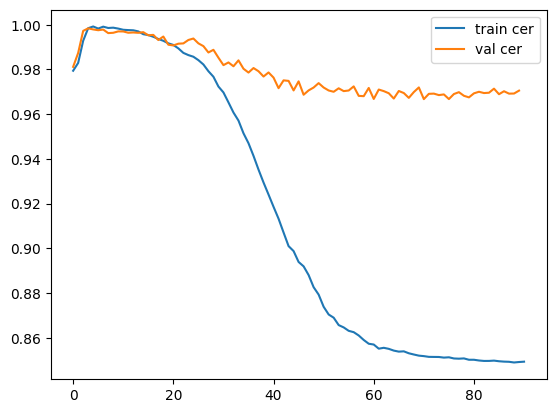

In [73]:
plt.plot(train_cer, label='train cer')
plt.plot(val_cer, label='val cer')
plt.legend()

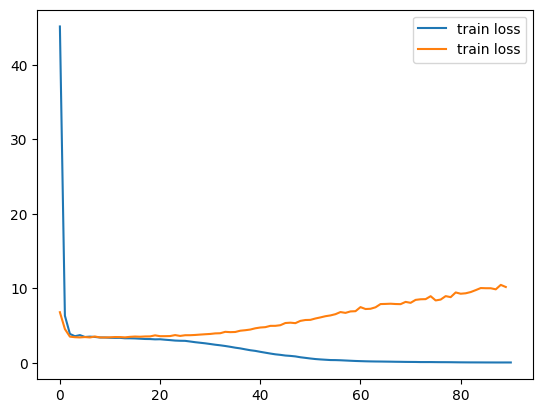

In [74]:
plt.plot([math.log(i) for i in train_loss], label='train loss')
plt.plot([math.log(i) for i in val_loss], label='train loss')
plt.legend()

In [75]:
torch.save(model, 'arina1903.torch')